In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import RobertaModel, RobertaConfig, RobertaTokenizer

from transformers import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import textwrap
import math
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()

In [2]:
df_train = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/train.csv')
df_val = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/val.csv')
df_test = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/test.csv')

In [3]:
df_senti = pd.read_excel('/home/m_nsu/ICLR/Datasets/GoEmotion/sentiwords.xlsx')
conditions = [
    (df_senti['PosScore'] > df_senti['NegScore']),
    (df_senti['PosScore'] < df_senti['NegScore']),
    (df_senti['PosScore'] == df_senti['NegScore'])
    ]

values = ['Positive','Negative','Neutral']

df_senti = df_senti[['PosScore','NegScore','Word','Definition']]
df_senti['Sentiment'] = np.select(conditions, values)
df_senti = df_senti.dropna(axis=0)
df_senti.drop(columns=['PosScore', 'NegScore'], inplace=True)
df_senti = df_senti[['Word', 'Sentiment', 'Definition']]

In [4]:
df_train.dropna(inplace=True)

In [5]:
df_train.rename(columns={'Text': 'review'}, inplace=True)
df_val.rename(columns={'Text': 'review'}, inplace=True)
df_test.rename(columns={'Text': 'review'}, inplace=True)


df_train.rename(columns={'Mapped Sentiment': 'sentiment'}, inplace=True)
df_val.rename(columns={'Mapped Sentiment': 'sentiment'}, inplace=True)
df_test.rename(columns={'Mapped Sentiment': 'sentiment'}, inplace=True)

In [6]:
df_train.head()

,review,Emotions,sentiment
0,my favorite food is anything i did not have to...,neutral,3
1,now if he does off himself everyone will think...,neutral,3
2,why the fuck is bayless isoing,anger,1
3,to make her feel threatened,fear,1
4,dirty southern wankers,annoyance,1


In [7]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

df_train = filter_rows_by_values(df_train,'sentiment',[2,3])
df_test = filter_rows_by_values(df_test,'sentiment',[2,3])
df_val = filter_rows_by_values(df_val,'sentiment',[2,3])

In [8]:
df_train['emotion'], map = pd.factorize(df_train['Emotions'])

In [9]:
emotion_map = dict(zip(map, range(len(map))))
map_emotion = {v: k for k, v in emotion_map.items()}

In [10]:
emotion_map['gratitude']  # Get Encoded Label from Categorical Label
map_emotion[3]  # Get Categorical Label from Encoded Label

'gratitude'

In [11]:
df_val['emotion'] = df_val["Emotions"].apply(lambda x: emotion_map[x])
df_test['emotion'] = df_test["Emotions"].apply(lambda x: emotion_map[x])

In [12]:
MAX_LEN = 200
RANDOM_SEED = 42
device = torch.device(0)

In [13]:
PRE_TRAINED_MODEL_NAME = 'roberta-large'
config = RobertaConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
clear_output()
print(device)

cuda:0


In [14]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]


    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation = True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long),

    }

In [15]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
  )

In [16]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [18]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,config=config)
    self.FC = nn.Linear(config.hidden_size,2, bias=False)


  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
      pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict = False
      )
    pooled_output = torch.mean(pooled_output[0], dim=1) # Taking Averge pooled last layer embedding

    binary_out = self.FC(pooled_output)
    
    return binary_out

In [19]:
model = Classifier()
model = model.to(device)
clear_output()

In [20]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [21]:
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [22]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
sentiments = data['sentiments'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 200])
torch.Size([32, 200])


In [23]:
#del test
torch.cuda.empty_cache()

In [24]:
outs = model(input_ids, attention_mask)

In [25]:
outs

tensor([[-0.0678,  0.3341],
        [-0.0677,  0.2402],
        [-0.1093,  0.2249],
        [ 0.0137,  0.3333],
        [ 0.0391,  0.2449],
        [ 0.0517,  0.3534],
        [-0.0368,  0.1094],
        [ 0.0902,  0.3866],
        [-0.1260,  0.2425],
        [ 0.1266,  0.3623],
        [-0.0791,  0.2829],
        [ 0.1026,  0.3454],
        [ 0.1434,  0.1547],
        [ 0.0325,  0.2441],
        [-0.0610,  0.1391],
        [ 0.0164,  0.3234],
        [ 0.1372,  0.3946],
        [ 0.0945,  0.3396],
        [ 0.0195,  0.2806],
        [-0.0503,  0.2724],
        [ 0.2340,  0.4261],
        [-0.0060,  0.3402],
        [ 0.0019,  0.3550],
        [ 0.1309,  0.3965],
        [ 0.0828,  0.2484],
        [-0.0809,  0.2008],
        [ 0.0539,  0.3457],
        [ 0.0327,  0.4093],
        [ 0.0664,  0.2318],
        [-0.0216,  0.1343],
        [-0.0825,  0.3160],
        [ 0.0350,  0.3243]], device='cuda:0', grad_fn=<MmBackward0>)

In [26]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=0.001)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=math.floor((1./5)*total_steps),
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).to(device)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())


    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples, on_new=False):
  model = model.eval()

  losses = []
  f1s = []

  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      ).to(device)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

      f1s.append(f1_score(sentiments.cpu(), preds.cpu(), average='macro'))

  return correct_predictions.double() / n_examples, np.mean(losses), np.mean(f1s)

In [29]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss, val_f1 = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'baseline_xlnet_best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.5958956672808523 accuracy 0.6533018867924528
Val   loss 0.5034097489676898 accuracy 0.7516858389527965

Epoch 2/8
----------
Train loss 0.4736947440220877 accuracy 0.7699217181854677
Val   loss 0.43595584057554415 accuracy 0.7881792939309797

Epoch 3/8
----------
Train loss 0.4278349260744275 accuracy 0.804245283018868
Val   loss 0.41852075314219994 accuracy 0.7988893296310988

Epoch 4/8
----------
Train loss 0.41174918166802743 accuracy 0.812826174227218
Val   loss 0.40194029219542876 accuracy 0.8167393891312971

Epoch 5/8
----------
Train loss 0.40224149146298155 accuracy 0.8183460457647531
Val   loss 0.3998827128847943 accuracy 0.8199127330424435

Epoch 6/8
----------
Train loss 0.39465676520743304 accuracy 0.8226615816940988
Val   loss 0.3961127040129674 accuracy 0.82070606902023

Epoch 7/8
----------
Train loss 0.39616249164455775 accuracy 0.8199518265756724
Val   loss 0.39667220922965035 accuracy 0.8298294327647758

Epoch 8/8
----------
Train los

In [30]:
train_a = [i.item() for i in train_a]
train_l = [i.item() for i in train_l]
val_a = [i.item() for i in val_a]
val_l = [i.item() for i in val_l]

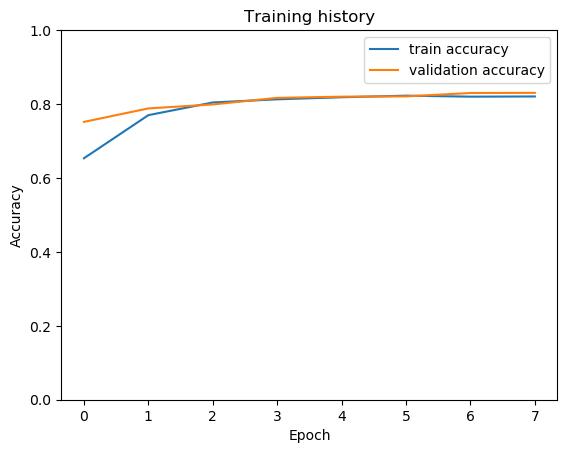

In [31]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Accuracy of Pos/Neg on Test Set

In [32]:
import numpy as np
test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.8173570019723866
F1-Macro:  0.7958848634866261


In [33]:
def get_predictions(model, data_loader):
  model = model.eval()

  review = []
  predictions = []

  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      reviews = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)


      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)


      probs = F.softmax(outputs, dim=1)

      review.extend(reviews)
      predictions.extend(preds)

      prediction_probs.extend(probs)
      real_values.extend(sentiments)



  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
class_names = ['negative', 'positive']

Pos/Neg Classification Report

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.87      0.86      1603
    positive       0.77      0.72      0.74       932

    accuracy                           0.82      2535
   macro avg       0.81      0.80      0.80      2535
weighted avg       0.82      0.82      0.82      2535

